In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import numpy as np

In [3]:
def reshape_data() -> pd.DataFrame:
    df = pd.read_csv('data/game/box_raw/bbref_game_counts.csv')
    home_games, away_games = pd.DataFrame(), pd.DataFrame()

    home_games = df[[col for col in df.columns if 'HOME_' in col]]
    home_games = home_games.rename(columns={
        col: col.replace('HOME_', '') for col in home_games.columns if 'HOME_' in col
    })
    home_games[['REST', 'OPPONENT', 'SEASON', 'DATE', 'GAME_TYPE']] = df[['HOME_REST', 'AWAY_TEAM', 'SEASON', 'DATE', 'GAME_TYPE']]
    home_games['IS_HOME'] = 1

    away_games = df[[col for col in df.columns if 'AWAY_' in col]]
    away_games = away_games.rename(columns={
        col: col.replace('AWAY_', '') for col in away_games.columns if 'AWAY_' in col
    })
    away_games[['REST', 'OPPONENT', 'SEASON', 'DATE', 'GAME_TYPE']] = df[['AWAY_REST', 'HOME_TEAM', 'SEASON', 'DATE', 'GAME_TYPE']]
    away_games['IS_HOME'] = 0

    all_games = pd.concat([home_games, away_games])
    all_games.sort_values(['SEASON', 'DATE', 'TEAM'], inplace=True)

    return all_games

In [9]:
all_games = reshape_data()
regular_season_games = all_games[all_games['GAME_TYPE'] == 'regular_season']

,TEAM,PTS,FGM,FGA,3PT_FGM,3PT_FGA,FTM,FTA,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,3PAR,FTR,ORTG,DRTG,GAME_NUMBER,REST,2PT_FGM,2PT_FGA,OPPONENT,SEASON,DATE,GAME_TYPE,IS_HOME
0,76E,101,38,66,3,8,22,30,8,29,37,27,10,5,14,24,0.121,0.455,118.7,84.6,1,1in3,35,58,KNI,2000-01,2000-10-31,regular_season,0
8,BLA,86,34,85,4,11,14,16,13,19,32,18,13,1,10,28,0.129,0.188,100.2,111.8,1,1in3,30,74,LAK,2000-01,2000-10-31,regular_season,1
5,BUC,93,33,83,6,19,21,26,17,34,51,16,6,7,20,27,0.229,0.313,98.1,102.3,1,1in3,27,64,MAV,2000-01,2000-10-31,regular_season,0
6,BUL,81,26,67,6,8,23,29,7,22,29,19,8,4,20,20,0.119,0.433,89.1,110.0,1,1in3,20,59,KIN,2000-01,2000-10-31,regular_season,1
9,CAV,86,32,78,2,7,20,32,11,41,52,16,5,8,19,27,0.090,0.410,89.4,85.3,1,1in3,30,71,NNE,2000-01,2000-10-31,regular_season,0


In [15]:
def analyze_rest_effects(df, stat='PTS'):
    """
    Analyze how rest affects team performance
    """
    print(f"\n=== Rest Effects Analysis for {stat} ===\n")
    
    # Create long-format dataset for this statistic
    data = df.copy()
    # Basic statistics by rest
    rest_stats = data.groupby(['REST', 'IS_HOME'])[stat].agg(['count', 'mean', 'std'])
    print("Statistics by rest days and home/away:")
    print(rest_stats)
    
    # ANOVA test
    for is_home in [0, 1]:
        subset = data[data['IS_HOME'] == is_home]
        f_stat, p_value = stats.f_oneway(*[group[stat].values 
                                         for name, group in subset.groupby('REST')])
        location = "home" if is_home else "away"
        print(f"\nANOVA test for {location} games:")
        print(f"F-statistic: {f_stat:.3f}")
        print(f"p-value: {p_value:.3e}")
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Box plot by rest
    sns.boxplot(data=data, x='REST', y=stat, ax=axes[0,0])
    axes[0,0].set_title(f'{stat} by Rest Days')
    
    # 2. Box plot by rest and home/away
    sns.boxplot(data=data, x='REST', y=stat, hue='IS_HOME', ax=axes[0,1])
    axes[0,1].set_title(f'{stat} by Rest Days and Home/Away')
    
    # 3. Mean and confidence intervals
    rest_means = data.groupby('REST')[stat].agg(['mean', 'std', 'count'])
    rest_means['ci'] = 1.96 * rest_means['std'] / np.sqrt(rest_means['count'])
    rest_means['mean'].plot(kind='bar', yerr=rest_means['ci'], ax=axes[1,0])
    axes[1,0].set_title(f'Mean {stat} by Rest Days (with 95% CI)')
    
    # 4. Density plot by rest
    for rest_days in sorted(data['REST'].unique()):
        sns.kdeplot(data=data[data['REST']==rest_days][stat], 
                   label=f'Rest {rest_days}', ax=axes[1,1])
    axes[1,1].set_title(f'{stat} Distribution by Rest Days')
    
    plt.tight_layout()
    plt.show()
    
    return rest_stats


=== Rest Effects Analysis for ORTG ===

Statistics by rest days and home/away:
              count        mean        std
REST IS_HOME                              
1in3 0         5271  106.216752  11.884496
     1         7066  108.990122  11.665293
2in2 0         8397  105.231642  11.920890
     1         4374  108.916712  11.777248
2in3 0        15153  107.021362  11.827974
     1        17381  109.553386  11.582459

ANOVA test for away games:
F-statistic: 61.885
p-value: 1.517e-27

ANOVA test for home games:
F-statistic: 8.968
p-value: 1.278e-04


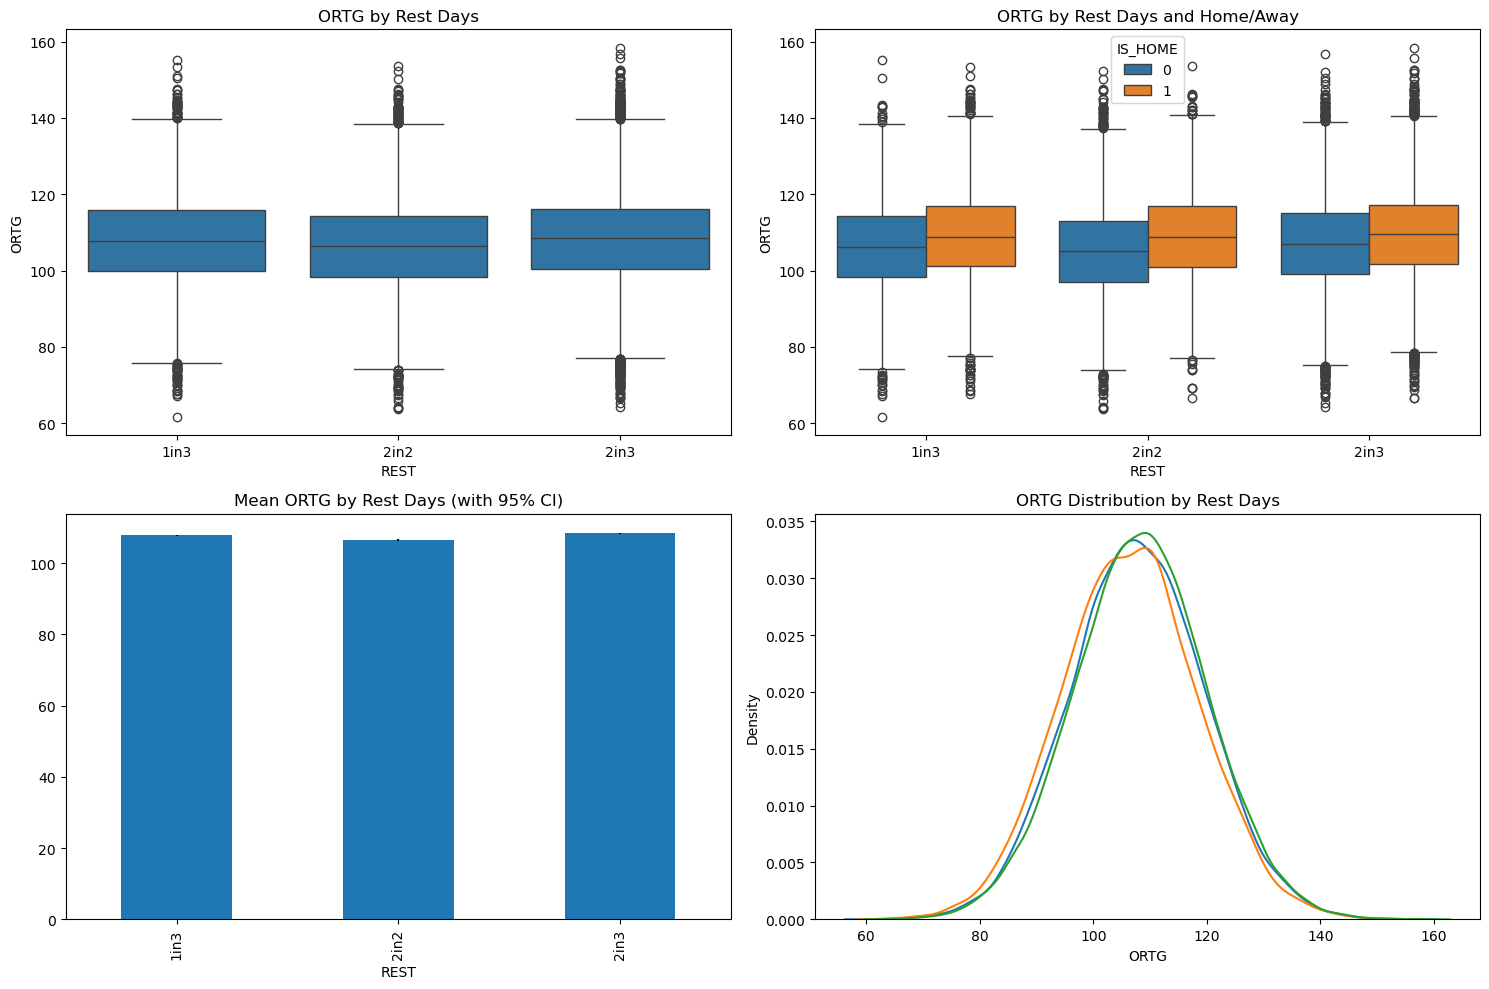

count        mean        std
REST IS_HOME                              
1in3 0         5271  106.216752  11.884496
     1         7066  108.990122  11.665293
2in2 0         8397  105.231642  11.920890
     1         4374  108.916712  11.777248
2in3 0        15153  107.021362  11.827974
     1        17381  109.553386  11.582459

In [22]:
analyze_rest_effects(regular_season_games, stat='ORTG')

In [20]:
def analyze_temporal_trends(df, stat='PTS'):
    """
    Analyze how rest effects change over time
    """
    print(f"\n=== Temporal Trends Analysis for {stat} ===\n")
    
    data = df.copy()
    
    # League-wide trends
    yearly_stats = data.groupby('SEASON')[stat].agg(['mean', 'std'])
    print("\nYearly league averages:")
    print(yearly_stats)
    
    # Rest effects by season
    rest_by_season = data.groupby(['SEASON', 'REST'])[stat].mean().unstack()
    print("\nRest effects by season:")
    print(rest_by_season)
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. League average over time
    yearly_stats['mean'].plot(ax=axes[0,0])
    axes[0,0].set_title(f'League Average {stat} Over Time')
    axes[0,0].fill_between(yearly_stats.index,
                          yearly_stats['mean'] - yearly_stats['std'],
                          yearly_stats['mean'] + yearly_stats['std'],
                          alpha=0.2)
    
    # 2. Rest effects over time
    rest_by_season.plot(ax=axes[0,1])
    axes[0,1].set_title('Rest Effects Over Time')
    
    # 3. Home advantage over time
    home_adv = data.groupby(['SEASON', 'IS_HOME'])[stat].mean().unstack()
    home_adv[1].subtract(home_adv[0]).plot(ax=axes[1,0])
    axes[1,0].set_title('Home Court Advantage Over Time')
    
    # 4. Rest effect sizes over time
    baseline_rest = rest_by_season.iloc[:,0]  # using first rest category as baseline
    for rest_cat in rest_by_season.columns[1:]:
        effect_size = (rest_by_season[rest_cat] - baseline_rest) / \
                     data.groupby('SEASON')[stat].std()
        effect_size.plot(ax=axes[1,1], label=f'Rest {rest_cat}')
    axes[1,1].set_title('Rest Effect Sizes Over Time')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
    return yearly_stats, rest_by_season


=== Temporal Trends Analysis for PTS ===


Yearly league averages:
               mean        std
SEASON                        
2000-01   94.810345  11.490434
2001-02   95.476451  11.529319
2002-03   95.087815  11.985466
2003-04   93.396552  12.063795
2004-05   97.198780  11.877266
2005-06   97.008537  11.970290
2006-07   98.739431  12.381557
2007-08   99.923171  12.923595
2008-09   99.950813  12.527855
2009-10  100.447154  11.904666
2010-11   99.550407  12.002419
2011-12   96.259596  11.635498
2012-13   98.137917  11.630666
2013-14  101.008943  11.860615
2014-15  100.014228  11.756692
2015-16  102.671545  11.740737
2016-17  105.610114  12.154306
2017-18  106.333333  12.065476
2018-19  111.208537  12.651393
2019-20  111.831767  12.438845
2020-21  112.099908  12.523645
2021-22  110.605178  12.603865
2022-23  114.652508  11.966101
2023-24  114.180275  12.840614

Rest effects by season:
REST           1in3        2in2        2in3
SEASON                                     
2000-01   95.

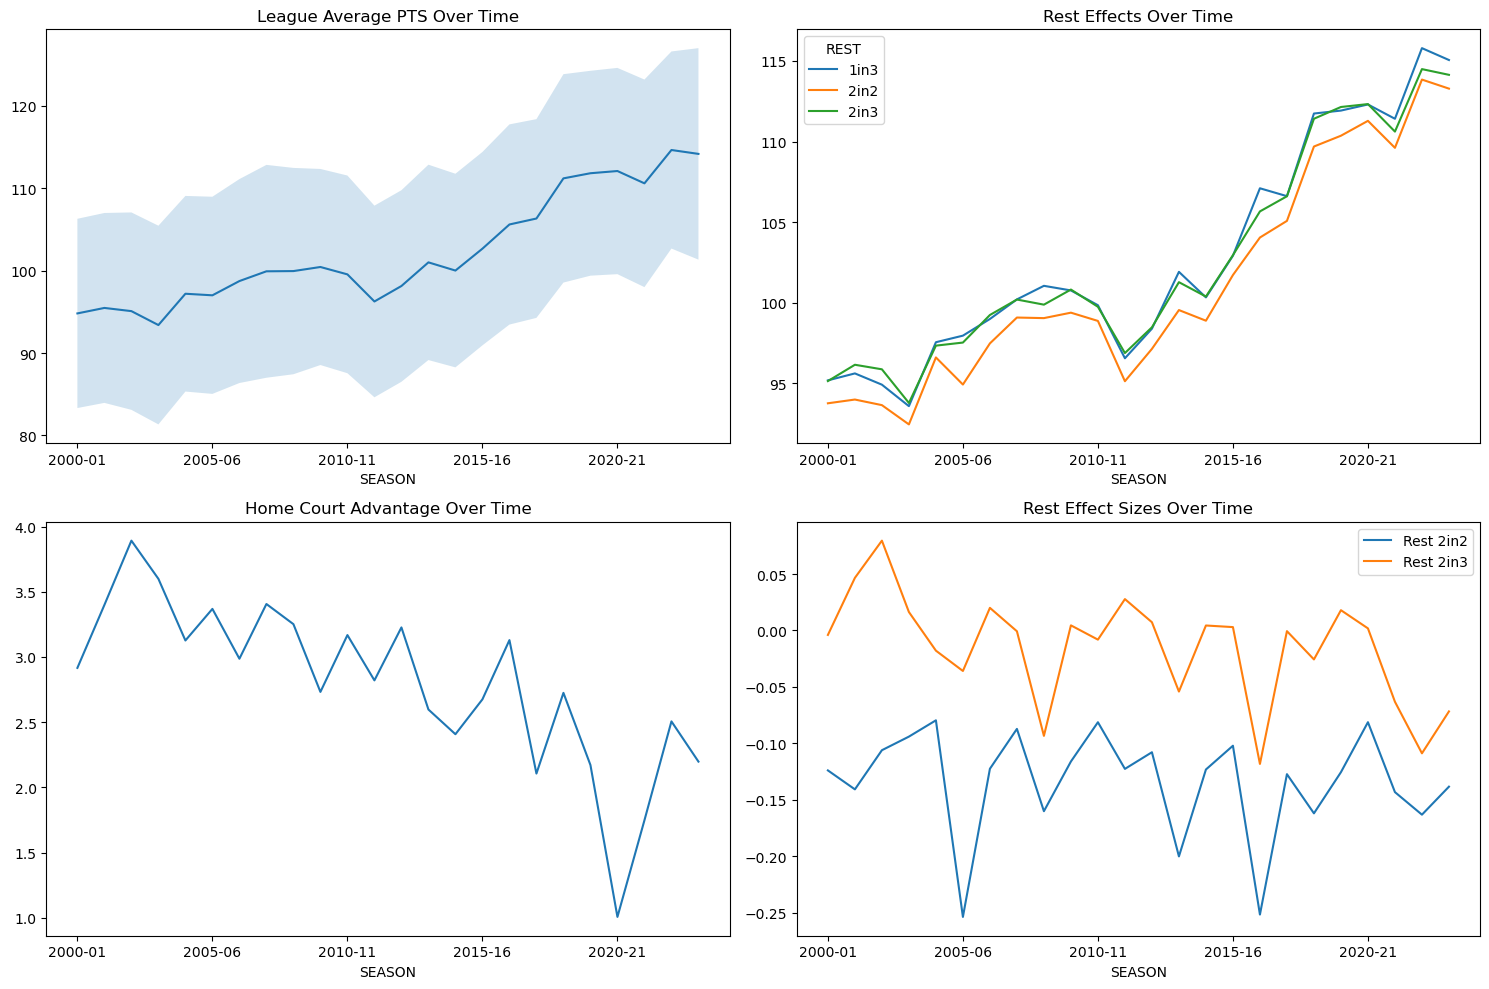

(               mean        std
 SEASON                        
 2000-01   94.810345  11.490434
 2001-02   95.476451  11.529319
 2002-03   95.087815  11.985466
 2003-04   93.396552  12.063795
 2004-05   97.198780  11.877266
 2005-06   97.008537  11.970290
 2006-07   98.739431  12.381557
 2007-08   99.923171  12.923595
 2008-09   99.950813  12.527855
 2009-10  100.447154  11.904666
 2010-11   99.550407  12.002419
 2011-12   96.259596  11.635498
 2012-13   98.137917  11.630666
 2013-14  101.008943  11.860615
 2014-15  100.014228  11.756692
 2015-16  102.671545  11.740737
 2016-17  105.610114  12.154306
 2017-18  106.333333  12.065476
 2018-19  111.208537  12.651393
 2019-20  111.831767  12.438845
 2020-21  112.099908  12.523645
 2021-22  110.605178  12.603865
 2022-23  114.652508  11.966101
 2023-24  114.180275  12.840614,
 REST           1in3        2in2        2in3
 SEASON                                     
 2000-01   95.176895   93.753927   95.131894
 2001-02   95.607843   93.986600

In [21]:
analyze_temporal_trends(regular_season_games)